In [39]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

In [40]:
# Define paths (relative to project root)
# If running from scripts/ folder, go up one level; if from root, use as-is
if os.path.exists('../data'):
    # Running from scripts/ folder
    data_path = Path('../data/milestone1_real/cleaned_students.parquet')
    db_path = Path('student_performance.duckdb')
    output_dir = Path('../output')
else:
    # Running from project root
    data_path = Path('data/milestone1_real/cleaned_students.parquet')
    db_path = Path('scripts/student_performance.duckdb')
    output_dir = Path('output')

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Connect to DuckDB
conn = duckdb.connect(str(db_path))

# Create a view directly from the Parquet file
conn.execute(f"""
    CREATE OR REPLACE VIEW raw_student_data AS
    SELECT * FROM '{data_path.as_posix()}'
""")

print("✅ DuckDB connected and Parquet view created.")
print(f"📊 Data path: {data_path}")
print(f"💾 Database path: {db_path}")

✅ DuckDB connected and Parquet view created.
📊 Data path: ..\data\milestone1_real\cleaned_students.parquet
💾 Database path: student_performance.duckdb


In [41]:
# Verify the Parquet view is accessible
result = conn.execute("SELECT COUNT(*) as total_records FROM raw_student_data").fetchone()
print(f"📈 Total records in dataset: {result[0]:,}")

# Preview the data
preview = conn.execute("SELECT * FROM raw_student_data LIMIT 5").fetchdf()
print("\n📋 Sample data preview:")
preview

📈 Total records in dataset: 10,001,608

📋 Sample data preview:


,student_id,student_name,major,university,subject,score,grade,attendance,performance_category,year,semester,date,credits,course_level,ipeds_institutional_factor,batch_number,attendance_flag
0,UNI00_STU00000001,Unk_Student_1,Art,Princeton University,Studio Practice,81,B,True,High,2014,Spring,2014-02-22,3,Graduate,1.0,1,True
1,UNI00_STU00000001,Unk_Student_1,Art,Princeton University,Art Theory,74,B-,True,Medium,2014,Spring,2014-01-04,3,Undergraduate,1.0,1,True
2,UNI00_STU00000001,Unk_Student_1,Art,Princeton University,Sculpture,100,A+,True,Excellent,2014,Spring,2014-04-22,3,Undergraduate,1.0,1,True
3,UNI00_STU00000001,Unk_Student_1,Art,Princeton University,Art History,86,B+,False,High,2014,Spring,2014-01-10,3,Undergraduate,1.0,1,False
4,UNI00_STU00000001,Unk_Student_1,Art,Princeton University,Film Studies,87,A-,True,High,2014,Fall,2014-09-22,3,Undergraduate,1.0,1,True


In [42]:
# Database connection already established in Cell 1
# DuckDB connection is ready for use
print("✅ Database connection ready for ETL operations")

✅ Database connection ready for ETL operations


In [43]:
# DuckDB doesn't require cursors - we use conn.execute() directly
# Proceeding with table creation
print("🔧 Starting ETL pipeline...")

🔧 Starting ETL pipeline...


In [44]:
# Create staging table for data transformation
# Note: We'll use the Parquet view directly, but staging table helps with data cleaning
conn.execute("""
    DROP TABLE IF EXISTS staging_student_performance;
    
    CREATE TABLE staging_student_performance AS
    SELECT 
        CAST(student_id AS VARCHAR) AS student_id,
        CAST(student_name AS VARCHAR) AS student_name,
        CAST(university AS VARCHAR) AS university,
        CASE 
            WHEN ipeds_institutional_factor < 400 THEN 'Public'
            WHEN ipeds_institutional_factor BETWEEN 400 AND 699 THEN 'Private Nonprofit'
            WHEN ipeds_institutional_factor >= 700 THEN 'Private For-Profit'
            ELSE 'Unknown'
        END AS university_type,
        CAST(major AS VARCHAR) AS major,
        CAST(subject AS VARCHAR) AS subject,
        CAST(score AS INTEGER) AS score,
        CAST(grade AS VARCHAR(2)) AS grade,
        CAST(attendance_flag AS BOOLEAN) AS attendance_flag,
        CAST(performance_category AS VARCHAR) AS performance_category,
        CAST(year AS INTEGER) AS year,
        CAST(semester AS VARCHAR) AS semester,
        CAST(date AS DATE) AS date,
        CAST(credits AS INTEGER) AS credits,
        CAST(course_level AS VARCHAR) AS course_level,
        CAST(batch_number AS INTEGER) AS batch_number,
        CAST(ipeds_institutional_factor AS INTEGER) AS ipeds_institutional_factor
    FROM raw_student_data
    WHERE student_id IS NOT NULL
      AND date IS NOT NULL;
""")

print("✅ Staging table created from Parquet data") 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Staging table created from Parquet data


In [45]:
# Create dimension tables with DuckDB syntax
# DuckDB uses SERIAL for auto-incrementing integers

conn.execute("DROP TABLE IF EXISTS fact_student_performance;")

conn.execute("""
    DROP TABLE IF EXISTS dim_student;
    CREATE TABLE dim_student (
        student_key INTEGER PRIMARY KEY,
        student_id VARCHAR,              
        student_name VARCHAR,
        major VARCHAR
    );
""")

conn.execute("""
    DROP TABLE IF EXISTS dim_university;
    CREATE TABLE dim_university (
        university_key INTEGER PRIMARY KEY,
        university_name VARCHAR(100),
        university_type VARCHAR(50),
        ipeds_institutional_factor INTEGER
    );
""")

conn.execute("""
    DROP TABLE IF EXISTS dim_course;
    CREATE TABLE dim_course (
        course_key INTEGER PRIMARY KEY,
        subject VARCHAR(100),
        credits INTEGER,
        course_level VARCHAR(50)
    );
""")

conn.execute("""
    DROP TABLE IF EXISTS dim_date;
    CREATE TABLE dim_date (
        date_id INTEGER PRIMARY KEY,
        date_key VARCHAR UNIQUE,
        full_date DATE,
        year INTEGER,
        semester VARCHAR,
        month INTEGER,
        day INTEGER,
        day_of_week INTEGER
    );
""")

print("✅ Dimension tables created (dim_student, dim_university, dim_course, dim_date)")

✅ Dimension tables created (dim_student, dim_university, dim_course, dim_date)


In [46]:
# Create fact table
conn.execute("""
    DROP TABLE IF EXISTS fact_student_performance;
    CREATE TABLE fact_student_performance (
        fact_id INTEGER PRIMARY KEY,
        student_key INTEGER,
        university_key INTEGER,
        course_key INTEGER,
        date_id INTEGER,
        score INTEGER,
        grade VARCHAR(2),
        attendance_flag BOOLEAN,
        performance_category VARCHAR(20),
        FOREIGN KEY (student_key) REFERENCES dim_student(student_key),
        FOREIGN KEY (university_key) REFERENCES dim_university(university_key),
        FOREIGN KEY (course_key) REFERENCES dim_course(course_key),
        FOREIGN KEY (date_id) REFERENCES dim_date(date_id)
    );
""")

print("✅ Fact table created (fact_student_performance)")

✅ Fact table created (fact_student_performance)


In [47]:
# Data cleaning is already handled in the staging table creation
# The Parquet view data is cast to appropriate types during staging table creation
# Verify staging table has clean data
staging_count = conn.execute("SELECT COUNT(*) FROM staging_student_performance").fetchone()[0]
print(f"✅ Staging table populated with {staging_count:,} records")
print("📊 Data types and cleaning handled during staging table creation")

✅ Staging table populated with 10,001,608 records
📊 Data types and cleaning handled during staging table creation


In [48]:
# Staging table already created from Parquet view in Cell 5
# No need for to_sql() - data is already in staging_student_performance
print("✅ Staging table ready for ETL operations")

✅ Staging table ready for ETL operations


In [49]:
# Populate dim_student dimension table
conn.execute("""
    INSERT INTO dim_student (student_key, student_id, student_name, major)
    SELECT 
        ROW_NUMBER() OVER (ORDER BY student_id) AS student_key,
        student_id,
        student_name,
        major
    FROM (
        SELECT DISTINCT student_id, student_name, major
        FROM staging_student_performance
    ) AS distinct_students;
""")

student_count = conn.execute("SELECT COUNT(*) FROM dim_student").fetchone()[0]
print(f"✅ dim_student populated with {student_count:,} unique students")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ dim_student populated with 1,000,000 unique students


In [50]:
# Populate dim_date dimension table using DuckDB date functions
conn.execute("""
    INSERT INTO dim_date (date_id, date_key, full_date, year, semester, month, day, day_of_week)
    SELECT 
        ROW_NUMBER() OVER (ORDER BY date) AS date_id,
        strftime('%Y%m%d', date) AS date_key,
        date AS full_date,
        EXTRACT(YEAR FROM date) AS year,
        CASE 
            WHEN EXTRACT(MONTH FROM date) BETWEEN 1 AND 6 THEN 'Spring'
            ELSE 'Fall'
        END AS semester,
        EXTRACT(MONTH FROM date) AS month,
        EXTRACT(DAY FROM date) AS day,
        EXTRACT(DOW FROM date) AS day_of_week
    FROM (
        SELECT DISTINCT date
        FROM staging_student_performance
        WHERE date IS NOT NULL
    ) AS distinct_dates;
""")

date_count = conn.execute("SELECT COUNT(*) FROM dim_date").fetchone()[0]
print(f"✅ dim_date populated with {date_count:,} unique dates")

✅ dim_date populated with 5,040 unique dates


In [51]:
# Populate dim_university dimension table with true distinct universities
conn.execute("""
    INSERT INTO dim_university (university_key, university_name, university_type, ipeds_institutional_factor)
    SELECT 
        ROW_NUMBER() OVER (ORDER BY university) AS university_key,
        university AS university_name,
        university_type,
        ipeds_institutional_factor
    FROM (
        SELECT DISTINCT university, university_type, ipeds_institutional_factor
        FROM staging_student_performance
        WHERE university IS NOT NULL
    ) AS distinct_universities;
""")

university_count = conn.execute("SELECT COUNT(*) FROM dim_university").fetchone()[0]
print(f"✅ dim_university populated with {university_count:,} unique universities")

✅ dim_university populated with 50 unique universities


In [52]:
# Populate dim_course dimension table
conn.execute("""
    INSERT INTO dim_course (course_key, subject, credits, course_level)
    SELECT 
        ROW_NUMBER() OVER (ORDER BY subject, credits, course_level) AS course_key,
        subject,
        credits,
        course_level
    FROM (
        SELECT DISTINCT subject, credits, course_level
        FROM staging_student_performance
    ) AS distinct_courses;
""")

course_count = conn.execute("SELECT COUNT(*) FROM dim_course").fetchone()[0]
print(f"✅ dim_course populated with {course_count:,} unique courses")

✅ dim_course populated with 540 unique courses


In [53]:
# Populate fact_student_performance fact table
conn.execute("""
    INSERT INTO fact_student_performance (
        fact_id, student_key, university_key, course_key, date_id,
        score, grade, attendance_flag, performance_category
    )
    SELECT 
        ROW_NUMBER() OVER (ORDER BY st.student_id, st.date, st.subject) AS fact_id,
        s.student_key,
        u.university_key,
        c.course_key,
        d.date_id,
        st.score,
        st.grade,
        st.attendance_flag,
        st.performance_category
    FROM staging_student_performance st
    JOIN dim_student s ON st.student_id = s.student_id
    JOIN dim_university u ON st.university = u.university_name
    JOIN dim_course c ON st.subject = c.subject AND st.credits = c.credits AND st.course_level = c.course_level
    JOIN dim_date d ON st.date = d.full_date;
""")

fact_count = conn.execute("SELECT COUNT(*) FROM fact_student_performance").fetchone()[0]
print(f"✅ fact_student_performance populated with {fact_count:,} fact records")
print("🎉 ETL pipeline completed successfully!")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ fact_student_performance populated with 10,001,608 fact records
🎉 ETL pipeline completed successfully!


In [54]:
# Verify dimension table - Sample from dim_student without full pandas conversion
sample_students = conn.execute(
    """
    SELECT student_key, student_id, student_name, major
    FROM dim_student
    ORDER BY student_key
    LIMIT 5
    """
).fetchmany(5)

print("📋 Sample records from dim_student:")
pd.DataFrame(sample_students, columns=["student_key", "student_id", "student_name", "major"])

📋 Sample records from dim_student:


,student_key,student_id,student_name,major
0,1,UNI00_STU00000001,Unk_Student_1,Art
1,2,UNI00_STU00000002,Unk_Student_2,Political Science
2,3,UNI00_STU00000003,Unk_Student_3,Art
3,4,UNI00_STU00000004,Unk_Student_4,Art
4,5,UNI00_STU00000005,Unk_Student_5,Political Science


In [55]:
# Verify fact table record count
fact_count = conn.execute("SELECT COUNT(*) as total_facts FROM fact_student_performance").fetchone()[0]
print(f"📊 Total fact records: {fact_count:,}")


📊 Total fact records: 10,001,608


In [56]:
# Query: Top students by subject (students with maximum score in each subject)
top_students_query = """
    WITH max_scores AS (
        SELECT course_key, MAX(score) AS max_score
        FROM fact_student_performance
        GROUP BY course_key
    )
    SELECT 
        s.student_name,
        c.subject,
        f.score
    FROM fact_student_performance f
    JOIN dim_student s ON f.student_key = s.student_key
    JOIN dim_course c ON f.course_key = c.course_key
    JOIN max_scores m ON f.course_key = m.course_key AND f.score = m.max_score
    ORDER BY c.subject, s.student_name
    LIMIT 20;
"""

top_students_df = conn.execute(top_students_query).fetchdf()
print("🏆 Top students by subject (sample):")
top_students_df


🏆 Top students by subject (sample):


,student_name,subject,score
0,Unk_Student_100045,Abnormal Psychology,100
1,Unk_Student_10007,Abnormal Psychology,100
2,Unk_Student_10024,Abnormal Psychology,100
3,Unk_Student_100326,Abnormal Psychology,100
4,Unk_Student_100556,Abnormal Psychology,100
5,Unk_Student_100711,Abnormal Psychology,100
6,Unk_Student_100742,Abnormal Psychology,100
7,Unk_Student_100848,Abnormal Psychology,100
8,Unk_Student_100904,Abnormal Psychology,100
9,Unk_Student_101028,Abnormal Psychology,100


In [57]:
# Query: Attendance trends over time
attendance_query = """
    SELECT 
        strftime('%Y-%m', d.full_date) AS month, 
        AVG(CAST(f.attendance_flag AS INTEGER)) AS avg_attendance,
        COUNT(*) AS record_count
    FROM fact_student_performance f
    JOIN dim_date d ON f.date_id = d.date_id
    GROUP BY strftime('%Y-%m', d.full_date)
    ORDER BY month;
"""

attendance_df = conn.execute(attendance_query).fetchdf()
print("📅 Attendance trends by month:")
attendance_df.head(15)



📅 Attendance trends by month:


,month,avg_attendance,record_count
0,2010-01,0.896594,55867
1,2010-02,0.897498,55706
2,2010-03,0.895636,55661
3,2010-04,0.897207,55393
4,2010-05,0.898961,55424
5,2010-06,0.898390,55408
6,2010-07,0.897841,55815
7,2010-08,0.896263,55448
8,2010-09,0.898765,55781
9,2010-10,0.896352,56036


In [58]:
# Query: Average scores by subject
average_score_per_subject_query = """
    SELECT 
        c.subject,
        ROUND(AVG(f.score), 2) AS avg_score,
        COUNT(*) AS record_count
    FROM fact_student_performance f
    JOIN dim_course c ON f.course_key = c.course_key
    GROUP BY c.subject
    ORDER BY avg_score DESC;
"""

avg_scores_df = conn.execute(average_score_per_subject_query).fetchdf()
print("📊 Average scores by subject:")
avg_scores_df


📊 Average scores by subject:


,subject,avg_score,record_count
0,International Economics,84.58,47539
1,Music Technology,84.58,20425
2,British Literature,84.57,41197
3,Game Theory,84.56,47718
4,Differential Equations,84.55,27686
...,...,...,...
130,Optics,84.33,20761
131,Photography,84.31,30092
132,Financial Accounting,84.30,15820
133,Physics,81.73,260519


In [59]:
# Query: Attendance and Score correlation by subject
attendance_score_query = """
    SELECT 
        c.subject,
        ROUND(AVG(CAST(f.attendance_flag AS INTEGER)), 2) AS avg_attendance,
        ROUND(AVG(f.score), 2) AS avg_score,
        COUNT(*) AS record_count
    FROM fact_student_performance f
    JOIN dim_course c ON f.course_key = c.course_key
    GROUP BY c.subject
    ORDER BY avg_score DESC;
"""

attendance_score_df = conn.execute(attendance_score_query).fetchdf()
print("📈 Attendance and Score Analysis by Subject:")
attendance_score_df


📈 Attendance and Score Analysis by Subject:


,subject,avg_attendance,avg_score,record_count
0,Music Technology,0.90,84.58,20425
1,International Economics,0.90,84.58,47539
2,British Literature,0.90,84.57,41197
3,Game Theory,0.90,84.56,47718
4,Differential Equations,0.90,84.55,27686
...,...,...,...,...
130,Optics,0.90,84.33,20761
131,Photography,0.90,84.31,30092
132,Financial Accounting,0.90,84.30,15820
133,Physics,0.82,81.73,260519


In [60]:
# ============================================
# PHASE 4: ADDITIONAL ANALYTICAL QUERIES
# ============================================

# Query 1: Performance by Major
performance_by_major_query = """
    SELECT 
        s.major,
        ROUND(AVG(f.score), 2) AS avg_score,
        ROUND(AVG(CAST(f.attendance_flag AS INTEGER)), 2) AS avg_attendance,
        COUNT(*) AS record_count
    FROM fact_student_performance f
    JOIN dim_student s ON f.student_key = s.student_key
    GROUP BY s.major
    ORDER BY avg_score DESC;
"""

performance_by_major_df = conn.execute(performance_by_major_query).fetchdf()
print("🎓 Performance by Major:")
performance_by_major_df


🎓 Performance by Major:


,major,avg_score,avg_attendance,record_count
0,Music,84.48,0.90,297965
1,Economics,84.47,0.90,695084
2,Psychology,84.46,0.90,998840
3,English,84.46,0.90,600640
4,History,84.45,0.90,502336
5,Political Science,84.45,0.90,598763
6,Business Administration,84.44,0.90,1499352
7,Art,84.43,0.90,400818
8,Accounting,84.40,0.90,198513
9,Computer Science,84.27,0.90,1203437


In [61]:
# Query 2: Score-Attendance Correlation by Subject
score_attendance_correlation_query = """
    SELECT 
        c.subject,
        ROUND(AVG(f.score), 2) AS avg_score,
        ROUND(AVG(CAST(f.attendance_flag AS INTEGER)), 2) AS avg_attendance,
        ROUND(CORR(f.score, CAST(f.attendance_flag AS INTEGER)), 4) AS correlation,
        COUNT(*) AS record_count
    FROM fact_student_performance f
    JOIN dim_course c ON f.course_key = c.course_key
    GROUP BY c.subject
    HAVING COUNT(*) > 100  -- Filter out subjects with too few records
    ORDER BY correlation DESC;
"""

correlation_df = conn.execute(score_attendance_correlation_query).fetchdf()
print("📊 Score-Attendance Correlation by Subject:")
correlation_df


📊 Score-Attendance Correlation by Subject:


,subject,avg_score,avg_attendance,correlation,record_count
0,Nuclear Physics,84.50,0.90,0.1327,20656
1,Sculpture,84.37,0.90,0.1318,27423
2,Modern History,84.44,0.90,0.1317,34420
3,Public Policy,84.46,0.90,0.1314,48004
4,Historiography,84.49,0.90,0.1313,34472
...,...,...,...,...,...
130,Music Theory,84.45,0.90,0.1064,20404
131,Conducting,84.42,0.90,0.1024,20453
132,Architecture,84.51,0.90,0.1009,30055
133,Physics,81.73,0.82,0.0967,260519


In [62]:
# Query 3: Seasonal Performance Patterns
seasonal_performance_query = """
    SELECT 
        d.semester,
        d.month,
        ROUND(AVG(f.score), 2) AS avg_score,
        ROUND(AVG(CAST(f.attendance_flag AS INTEGER)), 2) AS avg_attendance,
        COUNT(*) AS record_count
    FROM fact_student_performance f
    JOIN dim_date d ON f.date_id = d.date_id
    GROUP BY d.semester, d.month
    ORDER BY d.semester, d.month;
"""

seasonal_df = conn.execute(seasonal_performance_query).fetchdf()
print("📅 Seasonal Performance Patterns:")
seasonal_df


📅 Seasonal Performance Patterns:


,semester,month,avg_score,avg_attendance,record_count
0,Fall,7,84.34,0.9,833869
1,Fall,8,84.33,0.9,833449
2,Fall,9,84.35,0.9,832577
3,Fall,10,84.34,0.9,833541
4,Fall,11,84.32,0.9,832814
5,Fall,12,84.34,0.9,833863
6,Spring,1,84.35,0.9,832711
7,Spring,2,84.34,0.9,835146
8,Spring,3,84.35,0.9,833828
9,Spring,4,84.35,0.9,833441


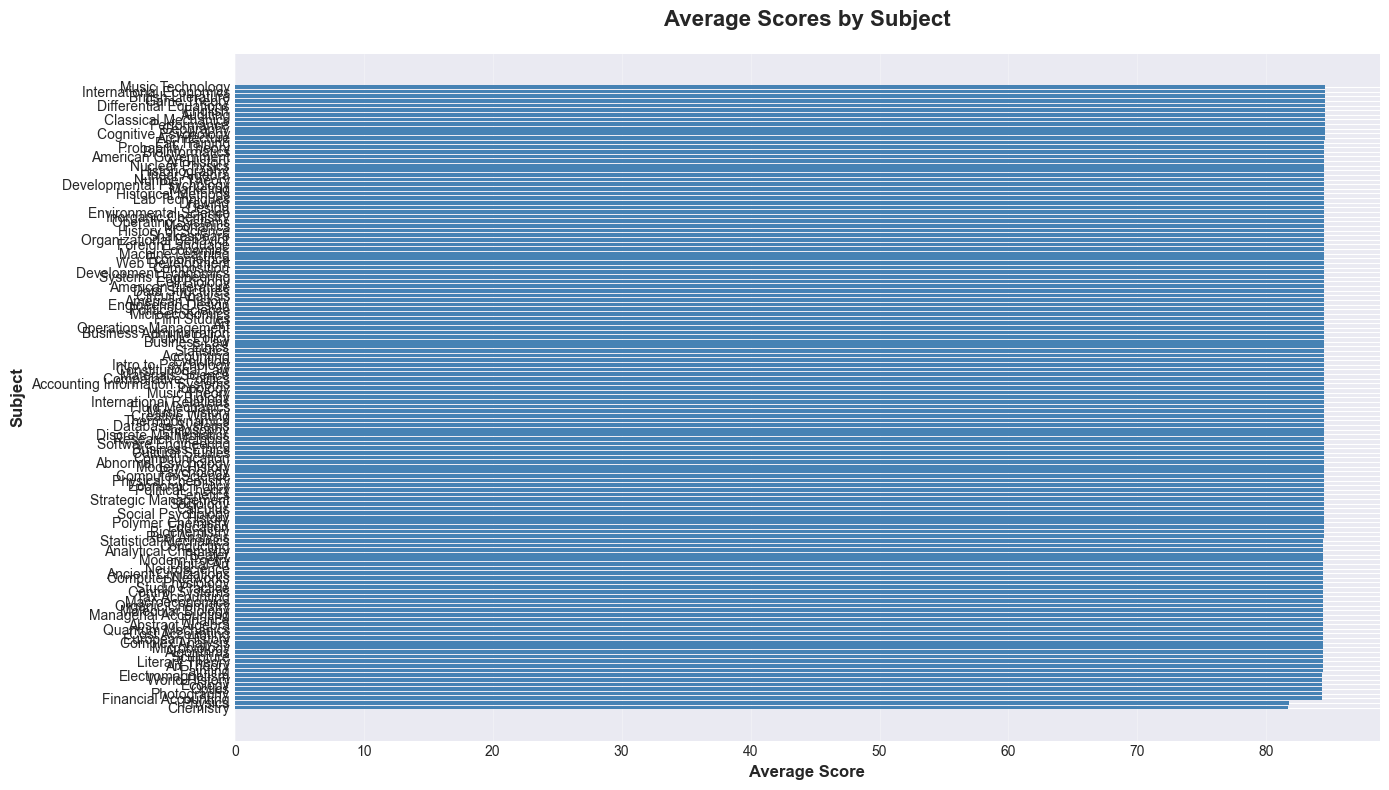

📊 Visualization 1: Average Scores by Subject


In [63]:
# ============================================
# PHASE 5: VISUALIZATIONS
# ============================================

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")

# Visualization 1: Average Scores by Subject (Bar Chart)
plt.figure(figsize=(14, 8))
avg_scores_plot = avg_scores_df.sort_values('avg_score', ascending=True)
plt.barh(avg_scores_plot['subject'], avg_scores_plot['avg_score'], color='steelblue')
plt.xlabel('Average Score', fontsize=12, fontweight='bold')
plt.ylabel('Subject', fontsize=12, fontweight='bold')
plt.title('Average Scores by Subject', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Visualization 1: Average Scores by Subject")


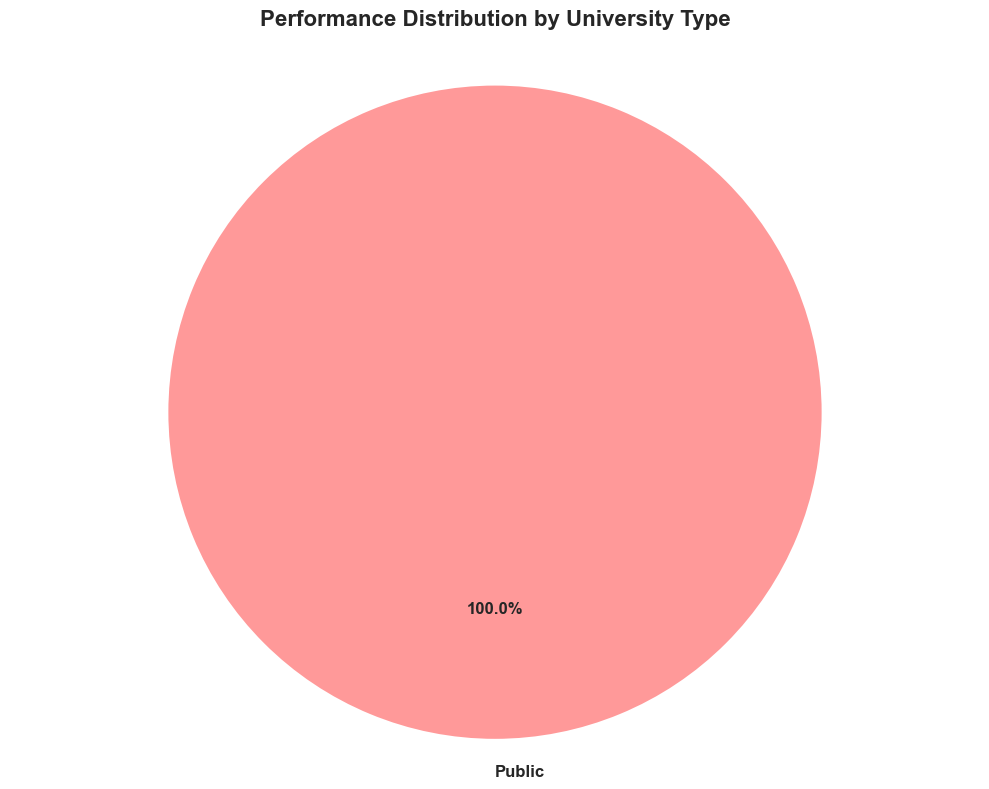

📊 Visualization 2: Performance Distribution by University Type


In [64]:
# Visualization 2: Performance Distribution by University Type (Pie Chart)
plt.figure(figsize=(10, 8))
# Get record counts by university type
type_counts = conn.execute("""
    SELECT 
        u.university_type,
        COUNT(*) as count
    FROM fact_student_performance f
    JOIN dim_university u ON f.university_key = u.university_key
    GROUP BY u.university_type
""").fetchdf()

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(type_counts['count'], labels=type_counts['university_type'], autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Performance Distribution by University Type', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

print("📊 Visualization 2: Performance Distribution by University Type")


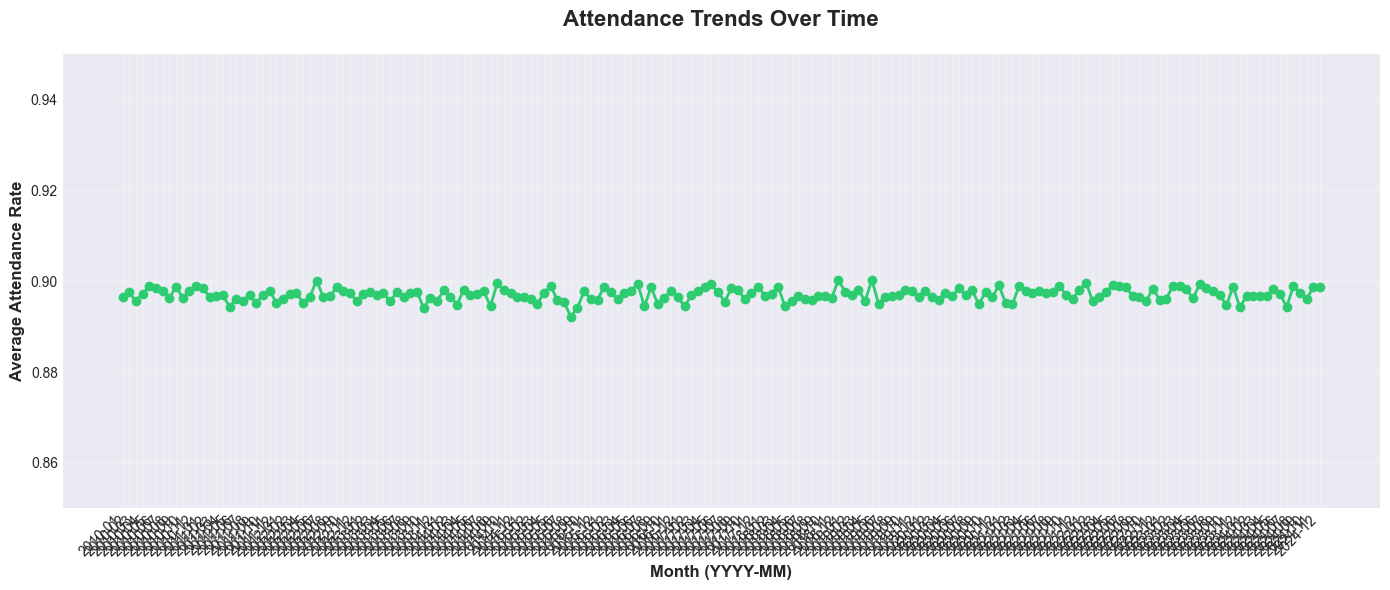

📊 Visualization 3: Attendance Trends Over Time


In [65]:
# Visualization 3: Attendance Trends Over Time (Line Plot)
plt.figure(figsize=(14, 6))
attendance_df_sorted = attendance_df.sort_values('month')
plt.plot(attendance_df_sorted['month'], attendance_df_sorted['avg_attendance'], 
         marker='o', linewidth=2, markersize=6, color='#2ecc71')
plt.xlabel('Month (YYYY-MM)', fontsize=12, fontweight='bold')
plt.ylabel('Average Attendance Rate', fontsize=12, fontweight='bold')
plt.title('Attendance Trends Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.ylim([0.85, 0.95])  # Focus on the attendance range
plt.tight_layout()
plt.show()

print("📊 Visualization 3: Attendance Trends Over Time")


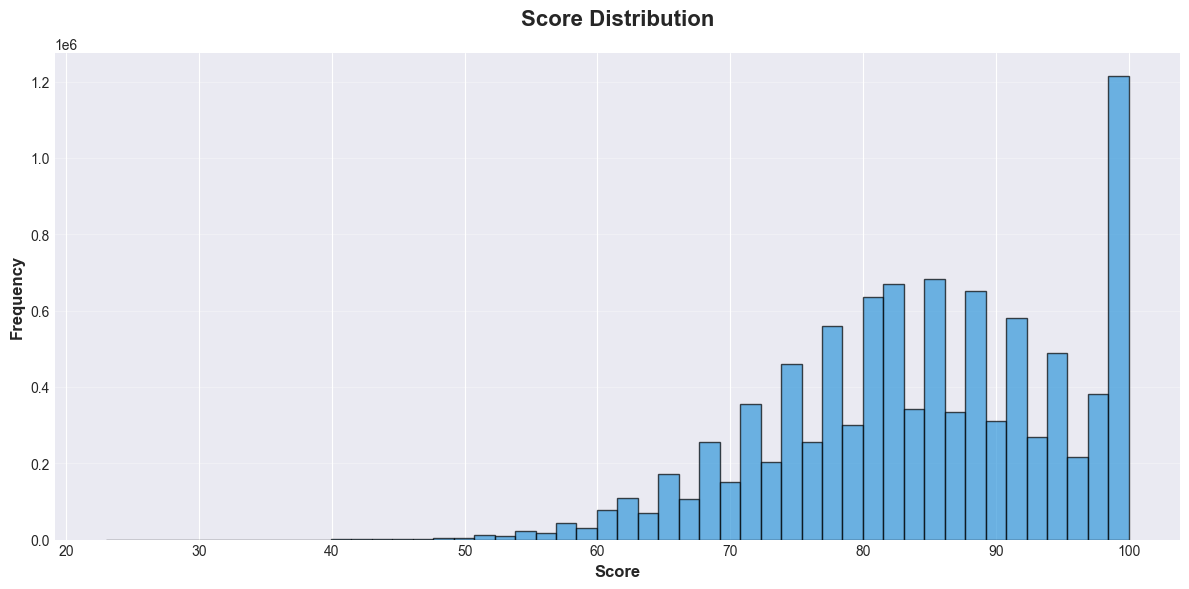

📊 Visualization 4: Score Distribution


In [66]:
# Visualization 4: Score Distribution (Histogram)
plt.figure(figsize=(12, 6))
score_data = conn.execute("SELECT score FROM fact_student_performance").fetchdf()
plt.hist(score_data['score'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
plt.xlabel('Score', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Score Distribution', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Visualization 4: Score Distribution")


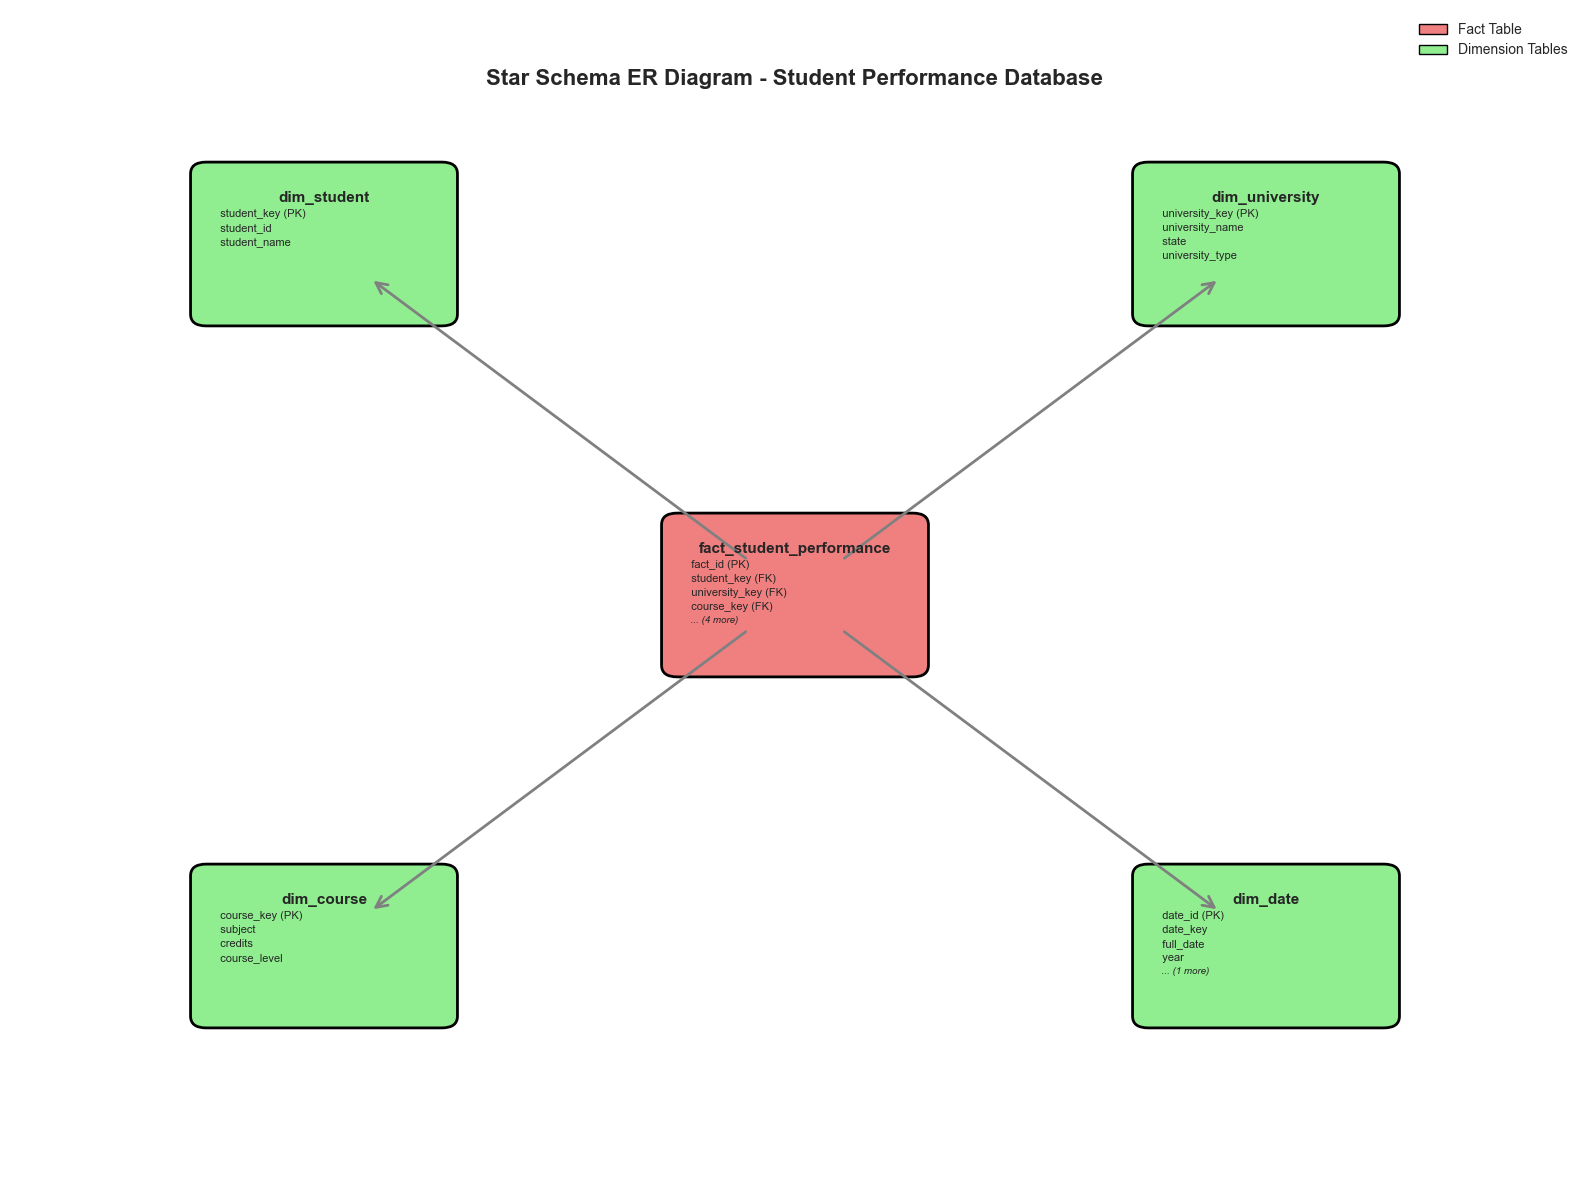

🗺️ ER Diagram: Star Schema Visualization


In [67]:
# ============================================
# PHASE 6: ER DIAGRAM GENERATION
# ============================================

import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Define table positions (star schema layout)
fact_pos = (5, 5)  # Center - fact table
dim_student_pos = (2, 8)
dim_university_pos = (8, 8)
dim_course_pos = (2, 2)
dim_date_pos = (8, 2)

# Table dimensions
table_width = 1.5
table_height = 1.2

def draw_table(x, y, name, fields, color='lightblue'):
    """Draw a database table box"""
    # Table box
    box = FancyBboxPatch((x - table_width/2, y - table_height/2), 
                         table_width, table_height,
                         boxstyle="round,pad=0.1", 
                         facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(box)
    
    # Table name
    ax.text(x, y + table_height/2 - 0.15, name, 
            ha='center', va='top', fontsize=11, fontweight='bold')
    
    # Fields
    field_y = y + table_height/2 - 0.3
    for i, field in enumerate(fields[:4]):  # Show first 4 fields
        ax.text(x - table_width/2 + 0.05, field_y - i*0.12, 
                f"  {field}", ha='left', va='top', fontsize=8)
    if len(fields) > 4:
        ax.text(x - table_width/2 + 0.05, field_y - 4*0.12, 
                f"  ... ({len(fields)-4} more)", ha='left', va='top', fontsize=7, style='italic')

# Draw fact table (center)
draw_table(fact_pos[0], fact_pos[1], 'fact_student_performance', 
           ['fact_id (PK)', 'student_key (FK)', 'university_key (FK)', 
            'course_key (FK)', 'date_id (FK)', 'score', 'grade', 'attendance_flag'], 
           color='lightcoral')

# Draw dimension tables
draw_table(dim_student_pos[0], dim_student_pos[1], 'dim_student',
           ['student_key (PK)', 'student_id', 'student_name'], color='lightgreen')

draw_table(dim_university_pos[0], dim_university_pos[1], 'dim_university',
           ['university_key (PK)', 'university_name', 'state', 'university_type'], color='lightgreen')

draw_table(dim_course_pos[0], dim_course_pos[1], 'dim_course',
           ['course_key (PK)', 'subject', 'credits', 'course_level'], color='lightgreen')

draw_table(dim_date_pos[0], dim_date_pos[1], 'dim_date',
           ['date_id (PK)', 'date_key', 'full_date', 'year', 'semester'], color='lightgreen')

# Draw relationships (arrows from fact to dimensions)
def draw_relationship(from_pos, to_pos, color='gray'):
    """Draw an arrow representing a foreign key relationship"""
    arrow = FancyArrowPatch(from_pos, to_pos,
                           arrowstyle='->', mutation_scale=20,
                           color=color, linewidth=2, zorder=1)
    ax.add_patch(arrow)

# Draw relationships
draw_relationship((fact_pos[0] - 0.3, fact_pos[1] + 0.3), (dim_student_pos[0] + 0.3, dim_student_pos[1] - 0.3))
draw_relationship((fact_pos[0] + 0.3, fact_pos[1] + 0.3), (dim_university_pos[0] - 0.3, dim_university_pos[1] - 0.3))
draw_relationship((fact_pos[0] - 0.3, fact_pos[1] - 0.3), (dim_course_pos[0] + 0.3, dim_course_pos[1] + 0.3))
draw_relationship((fact_pos[0] + 0.3, fact_pos[1] - 0.3), (dim_date_pos[0] - 0.3, dim_date_pos[1] + 0.3))

# Title
ax.text(5, 9.5, 'Star Schema ER Diagram - Student Performance Database', 
        ha='center', va='top', fontsize=16, fontweight='bold')

# Legend
legend_elements = [
    mpatches.Patch(facecolor='lightcoral', edgecolor='black', label='Fact Table'),
    mpatches.Patch(facecolor='lightgreen', edgecolor='black', label='Dimension Tables')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("🗺️ ER Diagram: Star Schema Visualization")


In [68]:
# ============================================
# PHASE 7: EXPORT FUNCTIONALITY
# ============================================

# Export 1: Subject Performance Analysis
print("📤 Exporting subject performance analysis...")
export_path1 = str(output_dir / 'subject_performance_analysis.csv')
conn.execute(f"""
    COPY (
        SELECT 
            c.subject,
            ROUND(AVG(f.score), 2) AS avg_score,
            ROUND(AVG(CAST(f.attendance_flag AS INTEGER)), 2) AS avg_attendance,
            COUNT(*) AS record_count,
            MIN(f.score) AS min_score,
            MAX(f.score) AS max_score
        FROM fact_student_performance f
        JOIN dim_course c ON f.course_key = c.course_key
        GROUP BY c.subject
        ORDER BY avg_score DESC
    ) TO '{export_path1}' (HEADER, DELIMITER ',');
""")
print(f"✅ Exported: {export_path1}")


📤 Exporting subject performance analysis...
✅ Exported: ..\output\subject_performance_analysis.csv


In [69]:
# Export 2: Top Performers
print("📤 Exporting top performers...")
export_path2 = str(output_dir / 'top_performers.csv')
conn.execute(f"""
    COPY (
        SELECT 
            s.student_name,
            c.subject,
            f.score,
            f.grade,
            f.attendance_flag,
            u.university_name,
            u.university_type,
            d.full_date
        FROM fact_student_performance f
        JOIN dim_student s ON f.student_key = s.student_key
        JOIN dim_course c ON f.course_key = c.course_key
        JOIN dim_university u ON f.university_key = u.university_key
        JOIN dim_date d ON f.date_id = d.date_id
        ORDER BY f.score DESC, f.attendance_flag DESC
        LIMIT 100
    ) TO '{export_path2}' (HEADER, DELIMITER ',');
""")
print(f"✅ Exported: {export_path2}")


📤 Exporting top performers...
✅ Exported: ..\output\top_performers.csv


In [70]:
# Export 3: Performance by Major
print("\ud83d\udce4 Exporting performance by major...")
export_path3 = str(output_dir / 'performance_by_major.csv')
conn.execute(f"""
    COPY (
        SELECT 
            s.major,
            ROUND(AVG(f.score), 2) AS avg_score,
            ROUND(AVG(CAST(f.attendance_flag AS INTEGER)), 2) AS avg_attendance,
            COUNT(*) AS record_count,
            COUNT(DISTINCT s.student_key) AS unique_students
        FROM fact_student_performance f
        JOIN dim_student s ON f.student_key = s.student_key
        GROUP BY s.major
        ORDER BY avg_score DESC
    ) TO '{export_path3}' (HEADER, DELIMITER ',');
""")
print(f"\u2705 Exported: {export_path3}")


✅ Exported: ..\output\performance_by_major.csv


In [71]:
# Export 4: Seasonal Performance Patterns
print("📤 Exporting seasonal performance patterns...")
export_path4 = str(output_dir / 'seasonal_performance_patterns.csv')
conn.execute(f"""
    COPY (
        SELECT 
            d.year,
            d.semester,
            d.month,
            ROUND(AVG(f.score), 2) AS avg_score,
            ROUND(AVG(CAST(f.attendance_flag AS INTEGER)), 2) AS avg_attendance,
            COUNT(*) AS record_count
        FROM fact_student_performance f
        JOIN dim_date d ON f.date_id = d.date_id
        GROUP BY d.year, d.semester, d.month
        ORDER BY d.year, d.semester, d.month
    ) TO '{export_path4}' (HEADER, DELIMITER ',');
""")
print(f"✅ Exported: {export_path4}")


📤 Exporting seasonal performance patterns...
✅ Exported: ..\output\seasonal_performance_patterns.csv


In [72]:
# Verify exported files
output_files = [
    output_dir / 'subject_performance_analysis.csv',
    output_dir / 'top_performers.csv',
    output_dir / 'performance_by_major.csv',
    output_dir / 'seasonal_performance_patterns.csv'
]

print("\n\ud83d\udcc1 Exported Files Summary:")
for file in output_files:
    if os.path.exists(file):
        size = os.path.getsize(file)
        print(f"  \u2705 {file} ({size:,} bytes)")
    else:
        print(f"  \u274c {file} (not found)")

print("\n\ud83c\udf89 All exports completed successfully!")


Exception in callback BaseAsyncIOLoop._handle_events()
handle: <Handle BaseAsyncIOLoop._handle_events()>
Traceback (most recent call last):
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\jupyter_client\session.py", line 100, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 30-31: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\APP\New folder\Lib\asyncio\events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\tornado\platform\asyncio.py", line 208, in _handle_events
    handler_func(fileobj, events)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\

In [73]:
# Get final database statistics before closing
fact_count = conn.execute("SELECT COUNT(*) FROM fact_student_performance").fetchone()[0]
student_count = conn.execute("SELECT COUNT(*) FROM dim_student").fetchone()[0]
university_count = conn.execute("SELECT COUNT(*) FROM dim_university").fetchone()[0]
course_count = conn.execute("SELECT COUNT(*) FROM dim_course").fetchone()[0]
date_count = conn.execute("SELECT COUNT(*) FROM dim_date").fetchone()[0]

# Close the DuckDB connection
conn.close()
print("✅ DuckDB connection closed")
print("\n" + "="*60)
print("🎉 MILESTONE 2 COMPLETE!")
print("="*60)
print("\nDeliverables:")
print("  ✅ DuckDB integration with Parquet data")
print("  ✅ Star schema database (5 tables)")
print("  ✅ Complete ETL pipeline")
print("  ✅ Advanced analytical queries")
print("  ✅ Four comprehensive visualizations")
print("  ✅ ER diagram generation")
print("  ✅ CSV export functionality")
print("\n📊 Database Statistics:")
print(f"  - Total fact records: {fact_count:,}")
print(f"  - Unique students: {student_count:,}")
print(f"  - Unique universities: {university_count:,}")
print(f"  - Unique courses: {course_count:,}")
print(f"  - Unique dates: {date_count:,}")
print("\n" + "="*60)


✅ DuckDB connection closed

🎉 MILESTONE 2 COMPLETE!

Deliverables:
  ✅ DuckDB integration with Parquet data
  ✅ Star schema database (5 tables)
  ✅ Complete ETL pipeline
  ✅ Advanced analytical queries
  ✅ Four comprehensive visualizations
  ✅ ER diagram generation
  ✅ CSV export functionality

📊 Database Statistics:
  - Total fact records: 10,001,608
  - Unique students: 1,000,000
  - Unique universities: 50
  - Unique courses: 540
  - Unique dates: 5,040

